# Simulation-based (likelihood-free) inference

## Galaxy clustering starter problem

**Siddharth Mishra-Sharma** ([smsharma@mit.edu](mailto:smsharma@mit.edu))

Here we will load up simulated halo particles from the [Quijote simulations](https://quijote-simulations.readthedocs.io/en/latest/) and build a simple feature-extractor using graph neural networks.

Try to use this learned feature extractor in conjunction with some of the SBI algorithms from previous tutorials to build a likelihood or posterior estimator for the cosmological parameters!

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# # Install PyTorch Geometric to deal with graphs
# ! pip install torch_geometric torch_cluster

## Look at the data

The data is available on Bridges-2 at `/ocean/projects/phy230064p/shared/quijote/`. If running elsewhere, download the galaxy point cloud data from [here](https://drive.google.com/drive/folders/16etX6fHLlJQqD9K_UIzAbiDFkSmAuIBu). 

This data was processed by Carol for [this project](https://github.com/smsharma/point-cloud-galaxy-diffusion/tree/main).

You could also use data from the [CAMELS hydro simulations](https://www.camel-simulations.org/), also processed and located on Bridges-2 as referenced in Carol's tutorial: https://github.com/florpi/iaifi-hackathon-2024-generative/blob/main/notebooks/pitch_camels.ipynb.

In [8]:
# Load galaxy point cloud data training
# x_train = np.load("../data/set_diffuser_data/train_halos.npy")  # If you download locally
x_train = np.load("/ocean/projects/phy230064p/shared/quijote/set_diffuser_data/train_halos.npy")  # If you run on Colab
x_train.shape  # (n_data, n_points, n_features); features are (x, y, z, vx, vy, vz, mass)

(1800, 5000, 7)

You can also find corresponding test samples etc in a similar format. You may combine them for convenience.

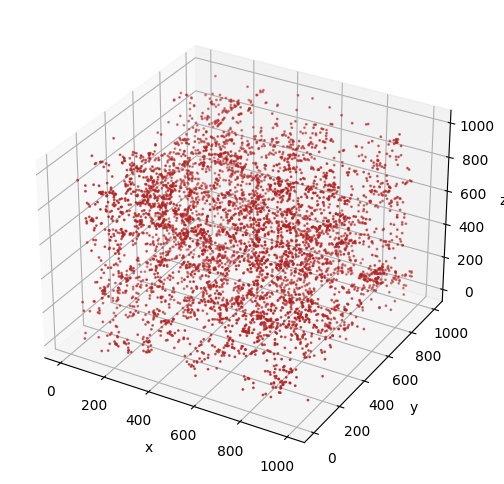

In [50]:
# Visualize a single point cloud

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[0, :, 0], x_train[0, :, 1], x_train[0, :, 2], s=1, color='firebrick')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [16]:
# Load corresponding cosmological parameters
theta_train = pd.read_csv("../data/set_diffuser_data/train_cosmology.csv")
theta_train.head()

,Omega_m,Omega_b,h,n_s,sigma_8
0,0.1755,0.06681,0.7737,0.8849,0.6641
1,0.2139,0.05557,0.8599,0.9785,0.8619
2,0.1867,0.04503,0.6189,0.8307,0.7187
3,0.3271,0.06875,0.6313,0.8135,0.8939
4,0.1433,0.06347,0.6127,1.1501,0.7699


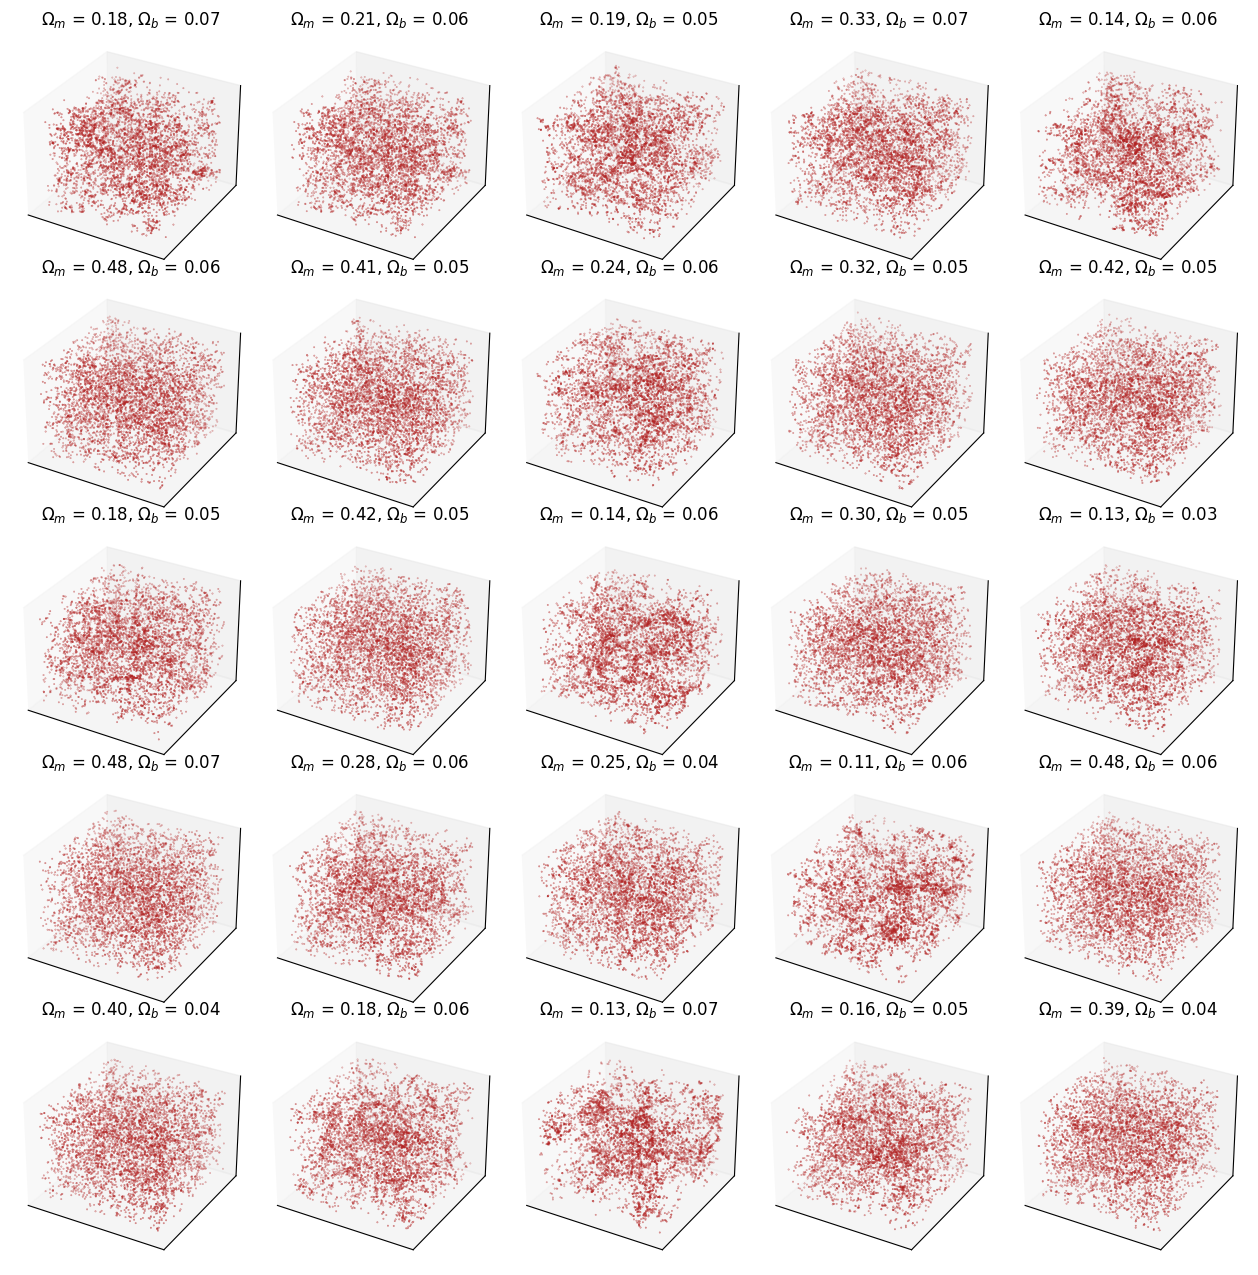

In [52]:
# Visualize a bunch of 3D point clouds with gridspec
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(5, 5)
gs.update(wspace=0.025, hspace=0.025)

for i in range(25):
    ax = plt.subplot(gs[i], projection='3d')
    ax.scatter(x_train[i, :, 0], x_train[i, :, 1], x_train[i, :, 2], s=0.1, color='firebrick')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # Title label with Omega_m, Omega_b columns from theta_train
    ax.set_title(r"$\Omega_m$ = %.2f, $\Omega_b$ = %.2f" % (theta_train["Omega_m"][i], theta_train["Omega_b"][i]))

## Building graphs

Build a graph based on a fixed distance cutoff (e.g. 50 Mpc/h) to facilitate processing the data with a graph neural network.

In [22]:
import torch_geometric
from torch_cluster import radius_graph

# Extract just the position features from x_train, for a small batch, to make the graph
n_batch = 4  # Number of point clouds to use in a batch to test
r_graph = 50  # At what radius to connect particles (in Mpc/h), with the box being 1000 Mpc/h to a side

x_pos = torch.tensor(x_train[:n_batch, :, :3], dtype=torch.float)      

# Build radius graph. x_pos is (n_data, n_points, 3), so flatten to (n_data * n_points, 3) and then build graph
batch = torch.repeat_interleave(torch.arange(x_pos.shape[0]), x_pos.shape[1])  # This just tells the radius_graph function which points belong to which point cloud
edge_index = radius_graph(x_pos.view(-1, 3), r=r_graph, batch=batch)

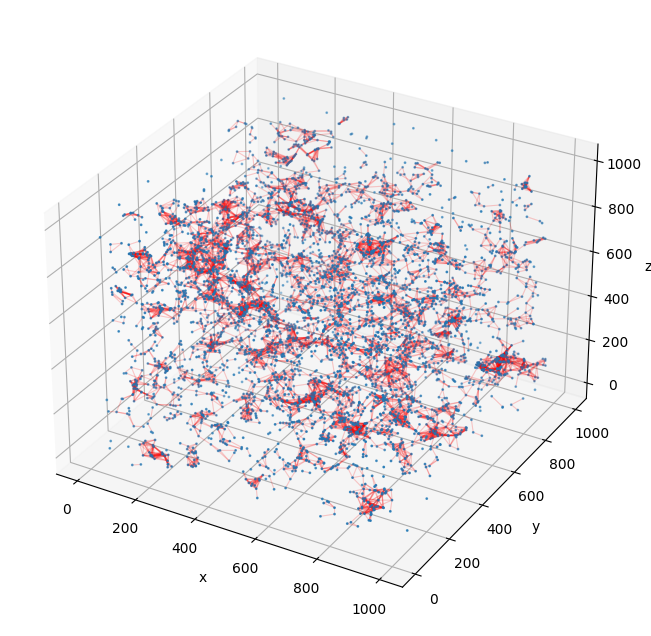

In [54]:
# Visualize the graph for one point cloud

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[0, :, 0], x_train[0, :, 1], x_train[0, :, 2], s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# `edge_index` has the graph edges for the entire batch of 4; extract only those corresponding to the first point cloud
edge_index_1 = edge_index[:, edge_index[1] < x_pos.shape[1]]

# Plot edges
for i in range(edge_index_1.shape[1]):
    ax.plot([x_pos[0, edge_index_1[0, i], 0], x_pos[0, edge_index_1[1, i], 0]],
            [x_pos[0, edge_index_1[0, i], 1], x_pos[0, edge_index_1[1, i], 1]],
            [x_pos[0, edge_index_1[0, i], 2], x_pos[0, edge_index_1[1, i], 2]], c='r', lw=0.8, alpha=0.1)
    
plt.show()

## The graph neural network (GNN) feature extractor

We'll build a simple GNN consisting of graph convolutions (aggregating information from neighboring nodes with message-passing) and node-wise nonlinearities.

See the PyTorch Geometric [GNN Cheatsheet](https://pytorch-geometric.readthedocs.io/en/latest/cheatsheet/gnn_cheatsheet.html) for more graph layers, adding edge weights (e.g. distances) etc.

<img src=./assets/gnn.png alt= “” width=800>

In [31]:
from torch_geometric.nn import GCNConv  # Graph convolutional layer from PyG

class GNN(torch.nn.Module):
    def __init__(self, in_channels=3, hidden_channels=32, out_features=64, num_layers=3):
        super(GNN, self).__init__()

        # Graph convolutional layers
        self.graph_layers = torch.nn.ModuleList()
        for i in range(num_layers):
            if i == 0:
                self.graph_layers.append(GCNConv(in_channels, hidden_channels))
            else:
                self.graph_layers.append(GCNConv(hidden_channels, hidden_channels))
        
        # Readout layer
        self.readout_layer = torch.nn.Linear(hidden_channels, out_features)

    def forward(self, x, edge_index, batch):
        for layer in self.graph_layers:
            x = torch.nn.functional.relu(layer(x, edge_index))
        
        # Mean-aggregate over nodes in each graph
        x = torch_geometric.nn.global_mean_pool(x, batch)
        x = self.readout_layer(x)
        return x

In [32]:
# Test instantiating GNN and running it on a small batch of data
gnn = GNN(in_channels=3, hidden_channels=32, out_features=64, num_layers=3)
features = gnn(x_pos.view(-1, 3), edge_index, batch)
features.shape

torch.Size([4, 64])

In [33]:
features  # Features for each graph in the batch

tensor([[ 26.8671,   8.9529, -12.4695, -12.1421,  13.1012,  19.8239,  49.2973,
         -49.1379, -24.1760,  55.1447, -40.9570,   6.0954,  34.9044,  63.4583,
         -13.8075,  14.9650, -15.9880, -59.4864, -15.8954, -62.9201,  22.6212,
          76.0580,  44.7861, -65.5813,  18.9074, -27.5692, -40.2528,   2.4791,
         -56.6850,  54.6712,  -5.1188,  40.3415, -40.6481, -28.2920, -70.3801,
         -49.0126,  57.1719,   7.7374, -28.7379, -14.9347, -49.4451,  15.0703,
          39.2132,  77.3551,  14.9582, -32.5661,   4.3548, -36.8568,  33.2929,
          -6.8479,  28.8881, -17.4328, -33.7248,  -3.9623, -14.0696,  43.5620,
           9.8468, -34.4234,  17.8984,  13.7771, -10.9401,   4.1405,  18.8496,
         -45.3101],
        [ 26.9562,   8.8582, -12.6129, -12.1525,  13.2473,  19.8051,  49.4058,
         -48.9583, -24.2306,  55.2269, -41.0036,   6.0990,  35.0205,  63.5939,
         -13.8102,  15.1210, -15.8996, -59.5490, -15.9659, -63.0399,  22.7171,
          76.1507,  44.8624, -65

## Simulation-based inference

Now, see if you can hook up this feature extract to a neural posterior or likelihood estimator for cosmological parameters e.g. ($\Omega_m, \sigma_8$), using code from previous tutorials! Target the cosmological parameters from `theta_train`.

Does using the GNN feature extractor give you tighter constraints than using a hand-crafted feature extractor, like the 2-point correlation function? Why or why not?

<img src=./assets/pspec.png alt= “” width=600>

For examples of working with graph data, see the PyG documentation: https://pytorch-geometric.readthedocs.io/en/latest/. You can use different, more powerful GNN layers, add edge weightings (e.g. distances between nodes) etc.